# Pre-processing and Modeling

* [1. Pre-processing](#1)
* [2. Modeling](#2)
    * [2.1 Mean-F1-score metrics function](#2.1)
    * [2.2 Baseline model](#2.2)
    * [2.3 A simple GRU](#2.3)
    * [2.4 A simple LSTM](#2.4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl # colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
import pickle
import sys

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.1
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
n_customers = 500
n_products = 3_000
product_ntimes = 10
last_n_orders = 30   # how many last orders to consider 

We are trying to predict the customer's next basket content using reccurent neural network based on the Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM) models. In the first part of this notebook we prepare the data, the second part covers the modeling.

## 1. Pre-processing <a id='1'></a>

Let's read in the files, set up some memory control and select from the file orders only those orders that correspond to train sample (prior and next orders).

In [5]:
orders         = pd.read_csv("./data/orders.csv",usecols=['order_id','user_id','eval_set','order_number'])
products_prior = pd.read_csv("./data/order_products__prior.csv")
products_train = pd.read_csv("./data/order_products__train.csv")
#products_sub   = pd.read_csv("./data/sample_submission.csv")

print(orders.shape)
print(products_prior.shape) 
print(products_train.shape) 
#print(products_sub.shape)

(3421083, 4)
(32434489, 4)
(1384617, 4)


In [6]:
def size(x,n=2):
    return '{} G'.format(round(sys.getsizeof(x)/1_000_000_000.,n))

In [7]:
print(size(orders))
print(size(products_prior))
print(size(products_train))

0.29 G
1.04 G
0.04 G


In [8]:
round(orders.memory_usage(deep=True).sum()/1_000_000_000.,2)

0.29

In [9]:
orders.head(15)

,order_id,user_id,eval_set,order_number
0,2539329,1,prior,1
1,2398795,1,prior,2
2,473747,1,prior,3
3,2254736,1,prior,4
4,431534,1,prior,5
5,3367565,1,prior,6
6,550135,1,prior,7
7,3108588,1,prior,8
8,2295261,1,prior,9
9,2550362,1,prior,10


In [10]:
products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
products_prior.shape, products_train.shape

((32434489, 4), (1384617, 4))

Select only users in the train sample (drop test sample)

In [13]:
uid = orders.groupby('user_id')['eval_set'].unique()
uid

user_id
1         [prior, train]
2         [prior, train]
3          [prior, test]
4          [prior, test]
5         [prior, train]
               ...      
206205    [prior, train]
206206     [prior, test]
206207     [prior, test]
206208     [prior, test]
206209    [prior, train]
Name: eval_set, Length: 206209, dtype: object

In [14]:
uid.astype('str').str.contains('train')

user_id
1          True
2          True
3         False
4         False
5          True
          ...  
206205     True
206206    False
206207    False
206208    False
206209     True
Name: eval_set, Length: 206209, dtype: bool

In [15]:
uid_train = uid[uid.astype('str').str.contains('train')].reset_index()
uid_train = uid_train.drop('eval_set',axis=1)
uid_train

,user_id
0,1
1,2
2,5
3,7
4,8
...,...
131204,206199
131205,206200
131206,206203
131207,206205


In [16]:
size(uid_train,3)

'0.001 G'

__We have 130k customers, let's choose only *n_customers* of them:__

In [17]:
uid_train_reduced = uid_train.head(n_customers)
uid_train_reduced.shape

(500, 1)

Now, let's merge it back with orders. 

In [18]:
orders_train = uid_train_reduced.merge(orders,on='user_id',how='left')
orders_train.head(50)

,user_id,order_id,eval_set,order_number
0,1,2539329,prior,1
1,1,2398795,prior,2
2,1,473747,prior,3
3,1,2254736,prior,4
4,1,431534,prior,5
5,1,3367565,prior,6
6,1,550135,prior,7
7,1,3108588,prior,8
8,1,2295261,prior,9
9,1,2550362,prior,10


In [19]:
orders_train.shape

(8163, 4)

In [20]:
orders_train = orders_train.groupby('user_id').tail(last_n_orders+1)

In [21]:
orders_train.shape

(6847, 4)

In [22]:
orders_train.head(50)

,user_id,order_id,eval_set,order_number
0,1,2539329,prior,1
1,1,2398795,prior,2
2,1,473747,prior,3
3,1,2254736,prior,4
4,1,431534,prior,5
5,1,3367565,prior,6
6,1,550135,prior,7
7,1,3108588,prior,8
8,1,2295261,prior,9
9,1,2550362,prior,10


In [23]:
#orders_train.groupby('user_id').apply(lambda x: print(x))

In [24]:
#orders_train['order_number'] = orders_train.groupby('user_id').apply(lambda x: x['order_number'] + last_n_orders + 1 - x['order_number'].max()).ravel()
#orders_train.head(50)
# x above is a dataframe, quicker with Series below

In [25]:
orders_train['order_number'] = orders_train.groupby('user_id')['order_number'].apply(lambda x: x - x.max() + last_n_orders + 1).ravel()
orders_train.head(50)

,user_id,order_id,eval_set,order_number
0,1,2539329,prior,21
1,1,2398795,prior,22
2,1,473747,prior,23
3,1,2254736,prior,24
4,1,431534,prior,25
5,1,3367565,prior,26
6,1,550135,prior,27
7,1,3108588,prior,28
8,1,2295261,prior,29
9,1,2550362,prior,30


In [26]:
#orders_train['order_number'] = orders_train.groupby('user_id').cumcount() +1
#orders_train.head(50)

In [27]:
orders_train.shape; size(orders_train)

'0.0 G'

In [28]:
reduced_list_orders_id = orders_train['order_id'].values
print(len(reduced_list_orders_id),reduced_list_orders_id)

6847 [2539329 2398795  473747 ...  655164 3145059 1971243]


One-hot-encode products:

How many products for this subsample?

In [29]:
products_prior_reduced = products_prior[products_prior['order_id'].isin(reduced_list_orders_id)]
products_train_reduced = products_train[products_train['order_id'].isin(reduced_list_orders_id)]
products_prior_reduced.shape, products_train_reduced.shape

((62350, 4), (5163, 4))

In [37]:
products = pd.concat((products_prior_reduced,products_train_reduced))
#products = products_prior_reduced
products.shape

(39044, 4)

In [38]:
print(size(products))

0.0 G


In [39]:
products['product_id'].value_counts().shape

(5209,)

5.2k unique products for 500 users

In [40]:
products['product_id'].value_counts()

13176    726
24852    663
47209    383
21137    356
21903    350
        ... 
29668      1
19459      1
29732      1
35963      1
11116      1
Name: product_id, Length: 5209, dtype: int64

In [41]:
n = products['product_id'].value_counts().shape[0]
x = range(n)
y = products['product_id'].value_counts().values

histogram:

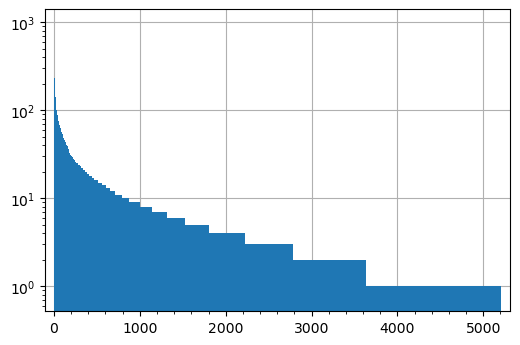

In [42]:
plt.hist(x,weights=y,bins=n,log=True);

cumulative distribution:

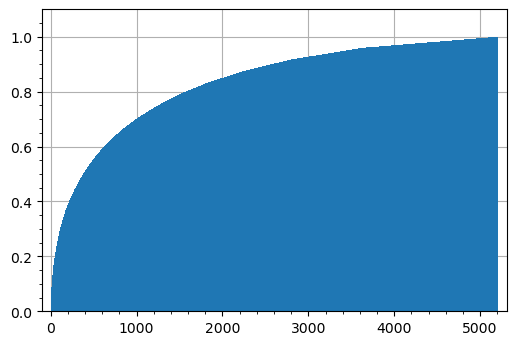

In [43]:
plt.hist(x,weights=y,bins=n,density=True,cumulative=True);

zoom it:

In [44]:
#plt.hist(x,weights=y,bins=n,density=True,cumulative=True);plt.xlim((0.,6500.));plt.ylim((0.5,1.));

In [45]:
# for all users, all orders
# 2000 - 72% working but very slow
# 1500 - 65% same slow
# 1000 - 60%
#  600 - 50% 

# the same fractions for reduced sample too, but there ARE! less products

One-hot-encode only those that appear at least *product_ntimes* times:

In [46]:
vc = products['product_id'].value_counts()
vc[vc >=product_ntimes]

13176    726
24852    663
47209    383
21137    356
21903    350
        ... 
46635     10
23178     10
42536     10
17454     10
43310     10
Name: product_id, Length: 877, dtype: int64

In [47]:
#topn = products['product_id'].value_counts().head(n_products).index
#len(topn),topn

topn = vc[vc > product_ntimes].index
len(topn),topn

(793,
 Int64Index([13176, 24852, 47209, 21137, 21903, 47766, 16797, 27966, 47626,
             27845,
             ...
             29223, 39190, 24082, 32953, 28647, 43210, 45223, 20754, 18432,
             21195],
            dtype='int64', length=793))

In [48]:
products = products[products['product_id'].isin(topn)]
products.shape, size(products)

((25444, 4), '0.0 G')

In [49]:
products['product_id'].nunique()

793

In [50]:
products = products.drop(['add_to_cart_order','reordered'],axis=1)

In [51]:
products.head()

,order_id,product_id
333,40,10070
334,40,42450
335,40,33198
336,40,34866
20714,2199,16953


In [52]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25444 entries, 333 to 1380182
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   order_id    25444 non-null  int64
 1   product_id  25444 non-null  int64
dtypes: int64(2)
memory usage: 596.3 KB


Before encoding, let's reduce the memory usage and convert the product_id type to the safest smaller uint number (uint16)

In [53]:
products['order_id'].min(),products['order_id'].max()

(40, 3420572)

In [54]:
products['product_id'].min(),products['product_id'].max()

(34, 49683)

In [55]:
# Int8 — [-128 : 127]
# Int16 — [-32768 : 32767]
# Int32 — [-2147483648 : 2147483647]
# Int64 — [-9223372036854775808 : 9223372036854775807]
#
# UInt8 — [0 : 255]
# UInt16 — [0 : 65535]
# UInt32 — [0 : 4294967295]

In [56]:
products['order_id'] = products['order_id'].astype('uint32')
products['product_id'] = products['product_id'].astype('uint16')

In [57]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25444 entries, 333 to 1380182
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   order_id    25444 non-null  uint32
 1   product_id  25444 non-null  uint16
dtypes: uint16(1), uint32(1)
memory usage: 347.9 KB


One-hot encode now:

In [58]:
def hot_encode(df,cols):
    return pd.get_dummies(df,columns=cols)

In [59]:
%%time
products_ohe_0 = hot_encode(products,['product_id'])

CPU times: user 104 ms, sys: 3.82 ms, total: 108 ms
Wall time: 107 ms


In [60]:
# dtypes: uint32(1), uint8(2000)
# memory usage: 6.8 GB
products_ohe_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25444 entries, 333 to 1380182
Columns: 794 entries, order_id to product_id_49683
dtypes: uint32(1), uint8(793)
memory usage: 19.5 MB


In [61]:
import dask.dataframe as dd
def ohe_sum_products_over_orders(x):
    df = dd.from_pandas(x,npartitions=2000) # 100 for 1k products, 2000 for 2k products didn't work
    return df.groupby('order_id').sum().compute()

this above is the bottle neck, the memory is saturated and the notebook shutsdown for any number > 1000. That's why we go with 1000.

In [62]:
products_ohe = ohe_sum_products_over_orders(products_ohe_0)

In [63]:
del products_ohe_0

In [64]:
type(products_ohe)

pandas.core.frame.DataFrame

In [65]:
products_ohe.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 5427 entries, 40 to 3420572
Columns: 793 entries, product_id_34 to product_id_49683
dtypes: uint8(793)
memory usage: 4.1 MB


In [66]:
products_ohe

,product_id_34,product_id_117,product_id_196,product_id_210,product_id_260,product_id_276,product_id_277,product_id_343,product_id_432,product_id_581,...,product_id_49175,product_id_49191,product_id_49235,product_id_49273,product_id_49383,product_id_49533,product_id_49610,product_id_49615,product_id_49621,product_id_49683
order_id,,,,,,,,,,,,,,,,,,,,,
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21708,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3418464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3418806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
products_ohe.sum(axis=1)

order_id
40         4
3733       5
13318      7
14172      6
21708      9
          ..
3417221    7
3418464    1
3418806    4
3419231    4
3420572    6
Length: 5427, dtype: int64

In [68]:
size(products_ohe)

'0.0 G'

In [69]:
#(10383795, 601)
products_ohe.shape

(5427, 793)

In [70]:
products_ohe.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 5427 entries, 40 to 3420572
Columns: 793 entries, product_id_34 to product_id_49683
dtypes: uint8(793)
memory usage: 4.1 MB


In [71]:
with open('./data/products_ohe_100customers_reordered.pkl', 'wb') as f:
        pickle.dump(products_ohe, f)

In [72]:
#with open('./data/products_ohe_reduced_{}.pkl'.format(n_products), 'rb') as f: 
#        products_ohe = pickle.load(f)

Finally, split into X and y. X corresponds to prior orders, y to train orders (if confused, think of "train" as "next" orders in the train sample).

In [73]:
orders_train_X = orders_train[orders_train['eval_set']=='prior'].drop('eval_set',axis=1)
orders_train_y = orders_train[orders_train['eval_set']=='train'].drop('eval_set',axis=1)

print(orders_train_X.shape,orders_train_y.shape)

(6347, 3) (500, 3)


In [74]:
size(orders_train_X),size(orders_train_y,3)

('0.0 G', '0.0 G')

In [75]:
del orders_train

Prepare X array

In [76]:
orders_train_X.head(30)

,user_id,order_id,order_number
0,1,2539329,21
1,1,2398795,22
2,1,473747,23
3,1,2254736,24
4,1,431534,25
5,1,3367565,26
6,1,550135,27
7,1,3108588,28
8,1,2295261,29
9,1,2550362,30


We want only last_n_orders. Reverse order_number and cut <= 20

In [77]:
#orders_train_X['order_number'] = orders_train_X.groupby('user_id').cumcount(ascending=False) + 1
#orders_train_X.head(20)

In [78]:
#orders_train_X = orders_train_X[orders_train_X['order_number'] <= last_n_orders]
#orders_train_X.shape

In [79]:
size(orders_train_X)

'0.0 G'

And reverse order_number back to the original numbers

In [80]:
#orders_train_X.head(20)

In [81]:
#orders_train_X['order_number'] = orders_train_X.groupby('user_id').cumcount(ascending=False) + 1

In [82]:
orders_train_X = orders_train_X.pivot(index='user_id',columns='order_number',values='order_id').fillna(0).astype('uint')
orders_train_X.head(20)

order_number,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,2539329,2398795,473747,2254736,431534,3367565,550135,3108588,2295261,2550362
2,0,0,0,0,0,0,0,0,0,0,...,1673511,1199898,3194192,788338,1718559,1447487,1402090,3186735,3268552,839880
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2717275,1909121,2267326,157374
7,0,0,0,0,0,0,0,0,0,0,...,565870,3239072,1175028,3060817,3120740,2425840,23391,2984707,369015,2452257
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,600894,2979257,2570360
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,280530,2762092,1830137
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1224907,68288,2115522,83395,1353310
13,0,0,0,0,0,0,0,0,0,0,...,2288946,19256,1378982,2363981,1906169,1757094,519471,2298068,1472646,1789302
14,0,0,0,0,0,0,0,0,0,0,...,1385564,1691859,2127409,2505309,3067644,2109666,1625325,1335295,2045336,3394109


In [83]:
#orders_train_X = orders_train_X[orders_train_X.columns[::-1]].stack()
orders_train_X = orders_train_X.stack()
orders_train_X.name = 'order_id'
orders_train_X = orders_train_X.reset_index()

In [84]:
orders_train_X.head(61)

,user_id,order_number,order_id
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,0
...,...,...,...
56,2,27,1402090
57,2,28,3186735
58,2,29,3268552
59,2,30,839880


In [85]:
orders_train_X.groupby('user_id')['order_number'].count().head()

user_id
1    30
2    30
5    30
7    30
8    30
Name: order_number, dtype: int64

In [86]:
orders_train_X = orders_train_X.drop('order_number',axis=1)
orders_train_X.head(31)

,user_id,order_id
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [87]:
orders_train_X.shape,size(orders_train_X)

((15000, 2), '0.0 G')

In [88]:
orders_train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   15000 non-null  int64 
 1   order_id  15000 non-null  uint64
dtypes: int64(1), uint64(1)
memory usage: 234.5 KB


In [89]:
orders_train_X['order_id'].min(),orders_train_X['order_id'].max()

(0, 3420572)

What's the highest value? 

In [90]:
orders_train_X['user_id'].max()

781

We can easily convert typefrom uint64 to uint8. 

Let's first merge X with products, then covert to uint8.

In [91]:
def merge(x,p):
    return x.merge(p,on='order_id',how='left').fillna(0).astype('uint')

In [92]:
orders_train_X = merge(orders_train_X,products_ohe)

In [93]:
orders_train_X.head(31)

,user_id,order_id,product_id_34,product_id_117,product_id_196,product_id_210,product_id_260,product_id_276,product_id_277,product_id_343,...,product_id_49175,product_id_49191,product_id_49235,product_id_49273,product_id_49383,product_id_49533,product_id_49610,product_id_49615,product_id_49621,product_id_49683
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
orders_train_X[orders_train_X.columns[2:]].sum(axis=1).head(31)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    2
22    2
23    3
24    4
25    3
26    3
27    3
28    5
29    4
30    0
dtype: int64

In [95]:
orders_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Columns: 795 entries, user_id to product_id_49683
dtypes: uint64(795)
memory usage: 91.1 MB


In [96]:
for col in orders_train_X.columns[2:]:
    orders_train_X[col] = orders_train_X[col].astype('uint8')

In [97]:
orders_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Columns: 795 entries, user_id to product_id_49683
dtypes: uint64(2), uint8(793)
memory usage: 11.7 MB


Prepare y array

Let's repeate the same steps for the y array. This one should be much quicker, as it has one less dimension to consider.

In [98]:
size(orders_train_y,3)

'0.0 G'

In [99]:
orders_train_y

,user_id,order_id,order_number
10,1,1187899,31
25,2,1492625,31
30,5,2196797,31
51,7,525192,31
55,8,880375,31
...,...,...,...
8116,775,3116656,31
8120,776,2248477,31
8147,777,2110387,31
8154,779,2354554,31


In [100]:
orders_train_y = orders_train_y.drop('order_number',axis=1)

In [101]:
orders_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 10 to 8162
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   500 non-null    int64
 1   order_id  500 non-null    int64
dtypes: int64(2)
memory usage: 11.7 KB


In [102]:
orders_train_y['order_id'].min(),orders_train_y['order_id'].max()

(988, 3412247)

In [103]:
orders_train_y['user_id'].max()

781

In [104]:
orders_train_y = merge(orders_train_y,products_ohe)

In [105]:
orders_train_y.head(20)

,user_id,order_id,product_id_34,product_id_117,product_id_196,product_id_210,product_id_260,product_id_276,product_id_277,product_id_343,...,product_id_49175,product_id_49191,product_id_49235,product_id_49273,product_id_49383,product_id_49533,product_id_49610,product_id_49615,product_id_49621,product_id_49683
0,1,1187899,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,1492625,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,2196797,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,525192,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,880375,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,9,1094988,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10,1822501,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,13,1827621,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,14,2316178,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,17,2180313,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
orders_train_y[orders_train_y.columns[2:]].sum(axis=1)

0      5
1      8
2      2
3      4
4      3
      ..
495    4
496    0
497    3
498    5
499    0
Length: 500, dtype: int64

In [107]:
orders_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Columns: 795 entries, user_id to product_id_49683
dtypes: uint64(795)
memory usage: 3.0 MB


In [108]:
for col in orders_train_y.columns[2:]:
    orders_train_y[col] = orders_train_y[col].astype('uint8')

In [109]:
orders_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Columns: 795 entries, user_id to product_id_49683
dtypes: uint64(2), uint8(793)
memory usage: 398.9 KB


Numpy X and y, saving to file:

In [110]:
xval = orders_train_X.groupby('user_id')['user_id'].head(1).values
yval = orders_train_y['user_id'].values
set(xval ==yval)

{True}

In [111]:
orders_train_X = orders_train_X.drop(['user_id','order_id'],axis=1)
orders_train_y = orders_train_y.drop(['user_id','order_id'],axis=1)

In [112]:
orders_train_X.head()

,product_id_34,product_id_117,product_id_196,product_id_210,product_id_260,product_id_276,product_id_277,product_id_343,product_id_432,product_id_581,...,product_id_49175,product_id_49191,product_id_49235,product_id_49273,product_id_49383,product_id_49533,product_id_49610,product_id_49615,product_id_49621,product_id_49683
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
orders_train_y.head()

,product_id_34,product_id_117,product_id_196,product_id_210,product_id_260,product_id_276,product_id_277,product_id_343,product_id_432,product_id_581,...,product_id_49175,product_id_49191,product_id_49235,product_id_49273,product_id_49383,product_id_49533,product_id_49610,product_id_49615,product_id_49621,product_id_49683
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
orders_train_X.sum(axis=1).head(31)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    2
22    2
23    3
24    4
25    3
26    3
27    3
28    5
29    4
30    0
dtype: int64

In [115]:
orders_train_y.sum(axis=1).head(30)

0     5
1     8
2     2
3     4
4     3
5     8
6     0
7     2
8     2
9     2
10    2
11    1
12    1
13    0
14    8
15    5
16    1
17    2
18    5
19    8
20    3
21    2
22    9
23    0
24    4
25    0
26    2
27    1
28    6
29    4
dtype: int64

In [116]:
orders_train_X.shape,orders_train_y.shape

((15000, 793), (500, 793))

In [117]:
size(orders_train_X),size(orders_train_y)

('0.01 G', '0.0 G')

In [118]:
orders_train_X.min().min(),orders_train_X.max().max()

(0, 1)

In [119]:
orders_train_y.min().min(),orders_train_y.max().max()

(0, 1)

In [120]:
orders_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Columns: 793 entries, product_id_34 to product_id_49683
dtypes: uint8(793)
memory usage: 11.5 MB


In [121]:
orders_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Columns: 793 entries, product_id_34 to product_id_49683
dtypes: uint8(793)
memory usage: 391.1 KB


In [122]:
X = orders_train_X.to_numpy()
y = orders_train_y.to_numpy()

In [123]:
print(X.nbytes/10**9,'G,',y.nbytes/10**9,'G')

0.011895 G, 0.0003965 G


In [124]:
#cols = orders_train_X.columns
pids = [col.split("_")[-1] for col in orders_train_X.columns]
print(pids[:15])

['34', '117', '196', '210', '260', '276', '277', '343', '432', '581', '651', '691', '780', '812', '890']


In [125]:
with open('./data/pids_for_cols_100customers.pkl', 'wb') as f:
        pickle.dump(pids, f)

In [126]:
del orders_train_X
del orders_train_y

What about the shape?

In [127]:
X.shape, y.shape

((15000, 793), (500, 793))

We need to reshape it to the desired 3-D format:

In [128]:
#X = np.reshape(X,(-1,last_n_orders,n_products))
#X = np.reshape(X,(n_customers,last_n_orders,-1))
X = np.reshape(X,(n_customers,-1,y.shape[1]))
X.shape,y.shape

((500, 30, 793), (500, 793))

Save them to a file:

In [129]:
with open('./data/xy_train_100customers_reordered.pkl', 'wb') as f:
        pickle.dump((X,y), f)

In [130]:
#!ls -lrt ./data/**pkl

## 2. Modeling <a id='2'></a>

Let's prepare the libraries to run the simplest LSTM model.

In [37]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import RepeatVector
#from keras.layers import TimeDistributed

from tensorflow.keras import initializers

from keras.callbacks import EarlyStopping
from keras.models import load_model

In [38]:
with open('./data/xy_train_100customers_reordered.pkl', 'rb') as f: 
        X,y = pickle.load(f)

In [39]:
X.shape,y.shape

((500, 30, 793), (500, 793))

In [40]:
last_n_orders = X.shape[1]
n_products  = X.shape[2]

In [41]:
print(X.nbytes/10**9,y.nbytes/10**9,'G')

0.011895 0.0003965 G


Let's split the data, assigning 25% of the training samples for a local model testing.

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=123)

In [43]:
del X, y

In [44]:
X_train.shape,y_train.shape

((375, 30, 793), (375, 793))

In [45]:
X_test.shape,y_test.shape

((125, 30, 793), (125, 793))

### 2.1 Mean-F1-score metrics function <a id='2.1'></a>

Let's prepare the metrics to check the performance of models.

In [46]:
def individual_score(y_true, y_pred):
    
    len_true = np.dot(y_true,y_true)
    len_pred = np.dot(y_pred,y_pred)
    len_comm = np.dot(y_true,y_pred)
        
    # both empty
    if len_true + len_pred == 0:
        return 1.,1.,1.

    # nothing in common (includes both: none vs sth and sth vs none, so no division by zero 
    if len_comm == 0: 
        return 0.,0.,0.
    
    p = 1. * len_comm / len_pred
    r = 1. * len_comm / len_true
    
    return p, r, 2 * p * r / (p + r)
    
def mean_precision_score(y_true, y_pred):

    return np.mean([individual_score(x, y)[0] for x, y in zip(y_true, y_pred)])    
    
def mean_recall_score(y_true, y_pred):

    return np.mean([individual_score(x, y)[1] for x, y in zip(y_true, y_pred)])       
    
def mean_f1_score(y_true, y_pred):

    return np.mean([individual_score(x, y)[2] for x, y in zip(y_true, y_pred)])

In [47]:
print(mean_f1_score([0,0],[0,0]),mean_f1_score([[1,0],[0,0]],[[0,0],[0,0]]),mean_f1_score([[0,0],[1,0]],[[1,1],[0,1]]))

1.0 0.5 0.0


### 2.2 Baseline model <a id='2.2'></a>

__NB: we only use products that appear at least 10 times, so the score is higher than what we would get if we used all the products. If all where used we would get mean f1 of the order of 0.34 just like for single models.__

Our baseline model will be to copy the customer's last order as a prediction. What's the score of this?:

For train sample:

In [48]:
y_train_pred = X_train[:,-1,:]
round(mean_f1_score(y_train,y_train_pred),3)

0.382

For test sample:

In [49]:
y_test_pred = X_test[:,-1,:]
round(mean_f1_score(y_test,y_test_pred),3)

0.462

Similar results, the score is 0.385 for the test sample. And what if we copy from earlier orders?:

In [50]:
x = np.linspace(1,last_n_orders,last_n_orders); y = []

for i in range(1,last_n_orders+1):
        
    y_test_pred  = X_test[:,-i,:]
    y.append(mean_f1_score(y_test ,y_test_pred))

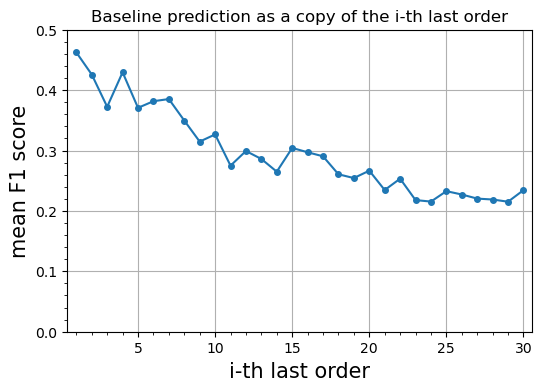

In [51]:
plt.rcParams.update({'axes.labelsize': 15})

plt.plot(x,y,marker='o',markersize=4); plt.ylim(0,0.5)

plt.title('Baseline prediction as a copy of the i-th last order')
plt.xlabel('i-th last order'); plt.ylabel('mean F1 score');

What if we sum up the last n orders, for n varying from 1 to 20:

In [52]:
x = np.linspace(1,last_n_orders,last_n_orders); z = []

for i in range(1,last_n_orders+1):
    
    X_test_reduced = X_test[:,-i:,:]
    X_test_ln = np.sum(X_test_reduced,axis=1)
    z.append(mean_f1_score(y_test ,X_test_ln))

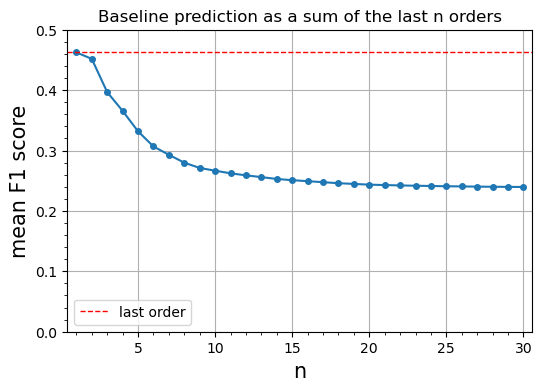

In [53]:
plt.rcParams.update({'axes.labelsize': 15})

plt.plot(x,z,marker='o',markersize=4); 
plt.ylim(0.,0.5)

plt.title('Baseline prediction as a sum of the last n orders')
plt.xlabel('n'); plt.ylabel('mean F1 score');
plt.axhline(z[0],c='r',linestyle='--',linewidth=1,label='last order');
plt.legend();

In [54]:
round(z[np.argmax(z)],3)

0.462

OK, let's move to deep learing now. 

Before we start model implementations, let's define the early stopping callback, which we will use for all the models we'll try below. It will stop training if the score doesn't improve after patience=3 consequtive interactions. Let's also prepare two plotting functons. 

In [55]:
#callback = EarlyStopping(patience=5,restore_best_weights=True)

#callback = EarlyStopping(patience=3,restore_best_weights=True)
callback = EarlyStopping(patience=10,restore_best_weights=True)
#callback = EarlyStopping(patience=30,restore_best_weights=True)

In [56]:
def plot_loss(h):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    #skip the very first n, to avoid high train
    n = 3
#    n = 6
    ax.plot(h.history['loss'][n:],marker='o',markersize=4)
    ax.plot(h.history['val_loss'][n:],marker='o',markersize=4)

    ax.set_xlabel('epoch',fontsize=18); ax.set_ylabel('Loss',fontsize=18); 
    ax.legend(['train', 'test'], fontsize=14);

In [57]:
def find_threshold(y_true,y_pred_prob):
    
    x = []; f = []; r = []; p = []
    
    for t in np.arange(0.,1.,0.01):
        
        y_pred = np.where(y_pred_prob > t, 1, 0)
        
        x.append(t)
        f.append(mean_f1_score(y_true,y_pred))
        r.append(mean_recall_score(y_true,y_pred))
        p.append(mean_precision_score(y_true,y_pred))
                       
    return x,f,r,p

def plot_threshold(x,f,r,p):
    plt.rcParams.update({'axes.labelsize': 15})

    plt.plot(x,p,marker='o',markersize=1)
    plt.plot(x,r,marker='o',markersize=1)
    plt.plot(x,f,marker='o',ls='--',markersize=1)
    plt.ylim(0.,0.5)

    thres = x[np.argmax(f)]
    plt.text(0.45,0.1,'Max F1 for P > {:.2f}'.format(thres))
    #plt.text(0.45,0.2,'Max F1 for P > {:.2f}'.format(thres))
    
    plt.title('Sigmoid threshold optimization')
    plt.xlabel('Probability threshold'); plt.ylabel('Mean score')
    plt.legend(['Mean Precision', 'Mean Recall','Mean F1 score'], fontsize=12);
    
    return thres

### 2.3 A simple GRU <a id='2.3'></a>

In [58]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.05)

model = Sequential()
model.add(GRU(n_products, activation='relu', input_shape=(last_n_orders,n_products),return_sequences=False,dropout=0.2, recurrent_dropout=0.2))#,kernel_initializer=initializer,recurrent_initializer=initializer))
model.add(Dense(n_products, activation='sigmoid'))#,kernel_initializer=initializer))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 793)               3777852   
_________________________________________________________________
dense_1 (Dense)              (None, 793)               629642    
Total params: 4,407,494
Trainable params: 4,407,494
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])

In [60]:
%%time

#h = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=50,callbacks=[callback])
h = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=100,callbacks=[callback])

Epoch 1/100
12/12 [==============================] - 11s 876ms/step - loss: 1.7260 - val_loss: 2.4123
Epoch 2/100
12/12 [==============================] - 10s 854ms/step - loss: 51.8121 - val_loss: 8.9980
Epoch 3/100
12/12 [==============================] - 11s 918ms/step - loss: 6.1945 - val_loss: 0.2474
Epoch 4/100
12/12 [==============================] - 11s 952ms/step - loss: 0.3930 - val_loss: 0.3935
Epoch 5/100
12/12 [==============================] - 12s 1s/step - loss: 0.2957 - val_loss: 0.1690
Epoch 6/100
12/12 [==============================] - 11s 931ms/step - loss: 0.1219 - val_loss: 0.1195
Epoch 7/100
12/12 [==============================] - 11s 892ms/step - loss: 0.0697 - val_loss: 0.1078
Epoch 8/100
12/12 [==============================] - 11s 946ms/step - loss: 0.0509 - val_loss: 0.0874
Epoch 9/100
12/12 [==============================] - 13s 1s/step - loss: 0.0428 - val_loss: 0.0793
Epoch 10/100
12/12 [==============================] - 13s 1s/step - loss: 0.0396 - val_

Epoch 81/100
12/12 [==============================] - 11s 938ms/step - loss: 0.0188 - val_loss: 0.0445
Epoch 82/100
12/12 [==============================] - 11s 889ms/step - loss: 0.0187 - val_loss: 0.0447
Epoch 83/100
12/12 [==============================] - 12s 974ms/step - loss: 0.0184 - val_loss: 0.0445
Epoch 84/100
12/12 [==============================] - 11s 889ms/step - loss: 0.0184 - val_loss: 0.0445
Epoch 85/100
12/12 [==============================] - 10s 858ms/step - loss: 0.0181 - val_loss: 0.0447
Epoch 86/100
12/12 [==============================] - 10s 867ms/step - loss: 0.0180 - val_loss: 0.0446
Epoch 87/100
12/12 [==============================] - 10s 859ms/step - loss: 0.0179 - val_loss: 0.0444
Epoch 88/100
12/12 [==============================] - 11s 896ms/step - loss: 0.0177 - val_loss: 0.0445
Epoch 89/100
12/12 [==============================] - 11s 885ms/step - loss: 0.0175 - val_loss: 0.0446
Epoch 90/100
12/12 [==============================] - 11s 881ms/step - lo

In [61]:
h.history.keys()

dict_keys(['loss', 'val_loss'])

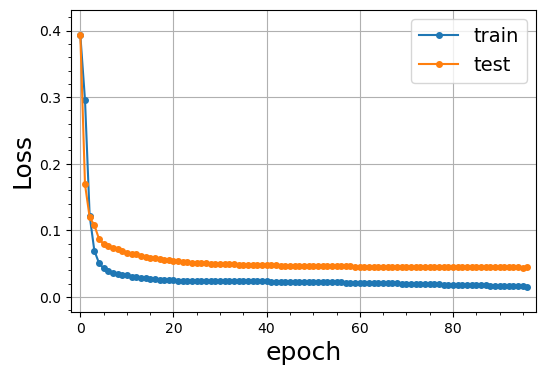

In [62]:
plot_loss(h)

In [63]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

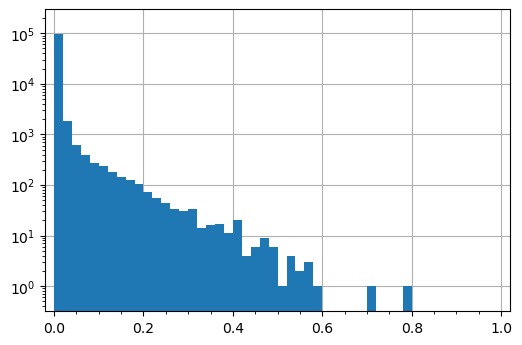

In [64]:
plt.hist(y_test_pred.ravel(),bins=50,range=(0,1),log=True);

In [65]:
x,f,r,p = find_threshold(y_test,y_test_pred)

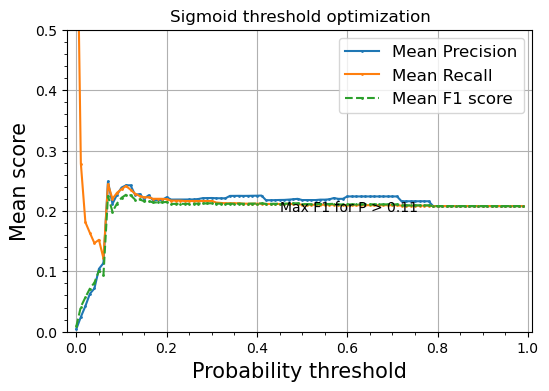

In [66]:
thres = plot_threshold(x,f,r,p)

In [67]:
y_train_pred_class = np.where(y_train_pred > thres, 1, 0)
y_test_pred_class  = np.where(y_test_pred  > thres, 1, 0)

In [68]:
print('train sample:',round(mean_f1_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_f1_score(y_test,y_test_pred_class),6))

train sample: 0.329788
test  sample: 0.226801


### 2.4 A simple LSTM <a id='2.4'></a>

Cool. Now let's build the first model. A simple LSTM and a dense layer

In [69]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.05)

model2 = Sequential()
model2.add(LSTM(n_products, activation='relu', input_shape=(last_n_orders,n_products),return_sequences=False,dropout=0.2, recurrent_dropout=0.2))#,kernel_initializer=initializer,recurrent_initializer=initializer))
model2.add(Dense(n_products, activation='sigmoid'))#,kernel_initializer=initializer))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 793)               5033964   
_________________________________________________________________
dense_2 (Dense)              (None, 793)               629642    
Total params: 5,663,606
Trainable params: 5,663,606
Non-trainable params: 0
_________________________________________________________________


In [70]:
model2.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])

In [71]:
%%time

#h2 = model2.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=50,callbacks=[callback])
h2 = model2.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=100,callbacks=[callback])

Epoch 1/100
12/12 [==============================] - 14s 1s/step - loss: 0.6368 - val_loss: 0.5370
Epoch 2/100
12/12 [==============================] - 12s 1s/step - loss: 0.3096 - val_loss: 0.0419
Epoch 3/100
12/12 [==============================] - 13s 1s/step - loss: 0.0364 - val_loss: 0.0313
Epoch 4/100
12/12 [==============================] - 13s 1s/step - loss: 0.0263 - val_loss: 0.0290
Epoch 5/100
12/12 [==============================] - 12s 1s/step - loss: 0.0249 - val_loss: 0.0286
Epoch 6/100
12/12 [==============================] - 12s 1s/step - loss: 0.0244 - val_loss: 0.0286
Epoch 7/100
12/12 [==============================] - 13s 1s/step - loss: 0.0240 - val_loss: 0.0288
Epoch 8/100
12/12 [==============================] - 13s 1s/step - loss: 0.0237 - val_loss: 0.0287
Epoch 9/100
12/12 [==============================] - 13s 1s/step - loss: 0.0235 - val_loss: 0.0293
Epoch 10/100
12/12 [==============================] - 14s 1s/step - loss: 0.0235 - val_loss: 0.0291
Epoch 11/

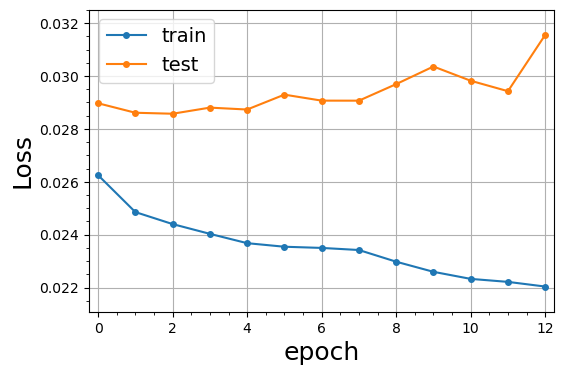

In [72]:
plot_loss(h2)

In [73]:
#model.save('./data/model211.h5')

In [74]:
#with open('./data/history211.pkl', 'wb') as f:
#    pickle.dump(h, f)

In [75]:
y_train_pred = model2.predict(X_train)
y_test_pred  = model2.predict(X_test)

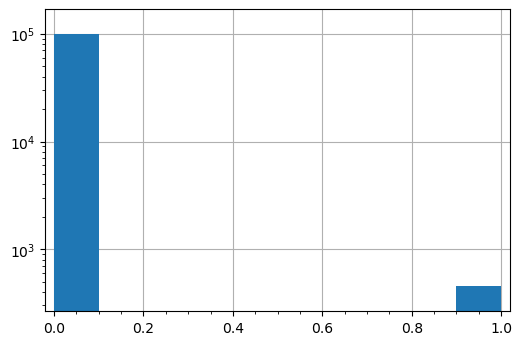

In [76]:
plt.hist(y_test.ravel(),log=True);

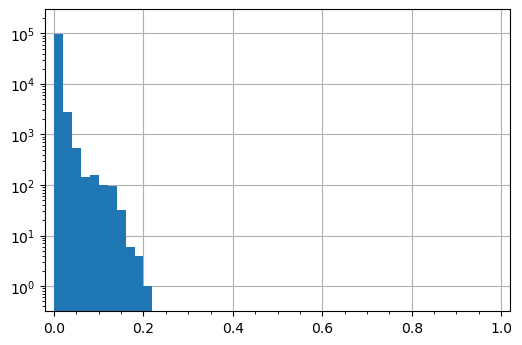

In [77]:
plt.hist(y_test_pred.ravel(),bins=50,range=(0,1),log=True);

Optimize threshold:

In [78]:
x,f,r,p = find_threshold(y_test,y_test_pred)

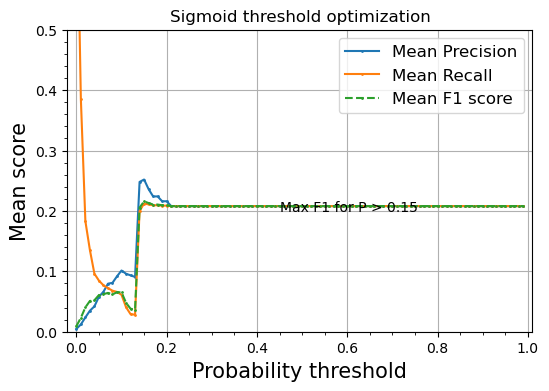

In [79]:
thres = plot_threshold(x,f,r,p)

In [80]:
y_train_pred_class = np.where(y_train_pred > thres, 1, 0)
y_test_pred_class  = np.where(y_test_pred  > thres, 1, 0)

Mean F1 score:

In [81]:
print('train sample:',round(mean_f1_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_f1_score(y_test,y_test_pred_class),6))

train sample: 0.186674
test  sample: 0.215738
